##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/images/image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/images/image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/images/image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial shows how to classify cats or dogs from images. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. You will get some practical experience and develop intuition for the following concepts:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

# Import packages

Let's start by importing the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python list to numpy array and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and validation data.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

This tutorial uses data available as `.zip` archive file. Use the `zipfile` module to extract its contents.

In [2]:
import zipfile

Import Tensorflow and the Keras classes needed to construct our model.

In [3]:
!brew install wget  # added by Miles
!pip install --upgrade --ignore-installed wrapt  # added by Miles
!pip install tensorflow==2.0.0-beta0  # modified by Miles: change to CPU version

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 3 taps (homebrew/core, homebrew/cask and caskroom/versions).
==> New Formulae
cjson                                    procs
clojure-lsp                              scala@2.12
docker-machine-driver-vmware             scdoc
drone-cli                                swig@3
dust                                     termshark
hey                                      terraformer
ipopt                                    virgil
newman
==> Updated Formulae
openssl ✔                                latex2html
sbcl ✔                                   ledger
akamai                                   lgogdownloader
angular-cli                              libbitcoin
ansible                                  libbitcoin-blockchain
anyenv                                   libbitcoin-client
arangodb                                 libbitcoin-database
aravis                                   libbitcoin-explorer
armadillo                               

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load data

Begin by downloading the dataset. This tutorial uses a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> dataset from Kaggle. Download the archive version of the dataset and store it in the "/tmp/" directory.

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-06-13 09:40:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.112
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  17.2MB/s    in 4.3s    

2019-06-13 09:40:53 (15.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Extract the dataset contents:

In [6]:
local_zip = '/tmp/cats_and_dogs_filtered.zip' # local path of downloaded .zip file
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp') # contents are extracted to '/tmp' folder
zip_ref.close()

The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [7]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [8]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understand the data

Let's look at how many cats and dogs images are in the training and validation directory:

In [9]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [10]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Set the model parameters

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [11]:
batch_size = 100
epochs = 15
IMG_SHAPE = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     # Its usually best practice to shuffle the training data
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [18]:

sample_training_images, _ = next(train_data_gen)

ImportError: Could not import PIL.Image. The use of `array_to_img` requires PIL.

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [19]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [20]:
plotImages(sample_training_images[:5])

NameError: name 'sample_training_images' is not defined

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it thatr is activated by a `relu` activation function. The model outputs class probabilities based on binary classification by the `sigmoid` activation function.

In [21]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3,)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

### Model summary

View all the layers of the network using the model's `summary` method:

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [24]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size)))
)

Epoch 1/15


ImportError: Could not import PIL.Image. The use of `array_to_img` requires PIL.

### Visualize training results

Now visualize the results after training the network.

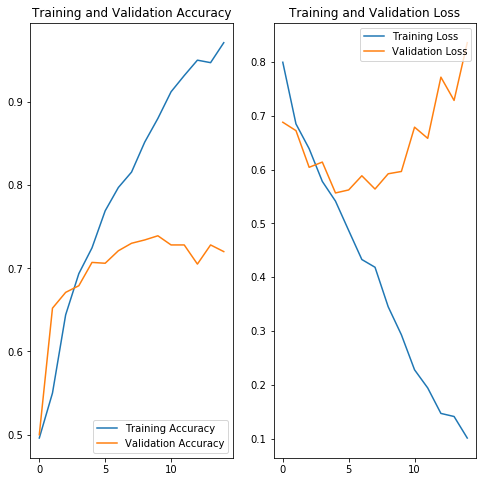

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **70%** accuracy on the validation set.

Let's look at what went wrong and try to increase overall performance of the model.

In [ ]:
# Note (added by Miles): this is the end of the code-along
# What we've learned: training a CNN from scratch 

# << End of Code-Along >>

In [25]:
# Note (added by Miles): the following is optional material
# A better solution to this network's poor performance is to use transfer learning!

# Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to our model.

To begin, clear the previous Keras session and start a new one:

In [ ]:
# Clear resources
tf.keras.backend.clear_session()
epochs = 80

# Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

## Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [ ]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [ ]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations. Here, you applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='binary'
                                                )

Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

# Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

# Creating a new network with Dropouts

Here, you apply dropout to first and last max pool layers and to a fully connected layer that has 512 output units. 30% of the first and last max pool layer, and 10% of fully connected layer output units, are randomly set to zero during each training epoch.

In [ ]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3,)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

model.summary()

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size)))
)

### Visualize the model

Visualize the new model after training and see if there are signs of overfitting:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluating the model

As you can see, the model's learning curves are much better than before and there is much less overfitting. The model is able to achieve an accuracy of ~*75%*.